In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import symulathon
from solve_system import solve_system
from recorder import SimulationReader
from backpropagation import Backpropagation

Loading mesh /home/magi/Documents/Project/Renderer/img/3d_axis.obj with TinyObj.


In [2]:
def newton_iteration(x0, v0):
    symulathon.fill_containers()
    A = symulathon.get_equation_matrix()
    b = symulathon.get_equation_vector()

    delta_v = solve_system(A, b)

    v2 = v0 + delta_v
    x2 = x0 + h * v2

    symulathon.set_state(x2, v2)
    
    
def newton_iterations(x0, v0, n=1):
    A = symulathon.get_equation_matrix()
    b = symulathon.get_equation_vector()

    delta_v = solve_system(A, b)

    v1 = v0 + delta_v
    x1 = x0 + h * v1
    symulathon.set_state(x1, v1)
    
    for i in range(n-1):
        newton_iteration(x0, v0)


In [3]:
def simulate():
    reader = SimulationReader(nDoF)
    backpropagation = Backpropagation(mass, h)
    symulathon.restart_simulation(K_GUESS)
    for _ in range(DIFF_FRAMES+1):
        ##################################
        # ALWAYS fill containers first!
        symulathon.fill_containers()
        ##################################

        x = symulathon.get_position()
        v = symulathon.get_velocity()
        x_t, v_t = reader.get_next_state()

        A = symulathon.get_equation_matrix()
        b = symulathon.get_equation_vector()

        dfdp = symulathon.get_parameter_jacobian()
        dfdx = symulathon.get_force_position_jacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        # delta_v = solve_system(A, b)
        # symulathon.recieve_delta_v(delta_v)
        newton_iterations(x, v)
        # symulathon.process_input()
        # symulathon.render_state()

    dgdp = backpropagation.get_dgdp()
    g = backpropagation.get_g()
    return (g, dgdp)

In [4]:
symulathon.initialize_scene()
symulathon.disable_rendering()
nDoF = symulathon.get_nDoF()
mass = symulathon.get_mass_matrix()
h = symulathon.get_time_step()
K_GUESS = 0.1
DIFF_FRAMES = 2



TinyObjReader: Material file [ 3d_axis_test.mtl ] not found in a path : /home/magi/Documents/Project/Renderer/img/
Failed to load material file(s). Use default material.
Loading mesh /home/magi/Documents/Project/Renderer/img/bunny.obj with TinyObj.


In [5]:
k_values = np.linspace(0.01, 10, 1000)
g_values = []
dgdp_values = []
for k in tqdm(k_values):
    K_GUESS = k
    g, dgdp = simulate()
    g_values.append(g)
    dgdp_values.append(dgdp[0])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (k_values[i+1] - k_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

1000 1000 1000 1000
0.00031915443188604335


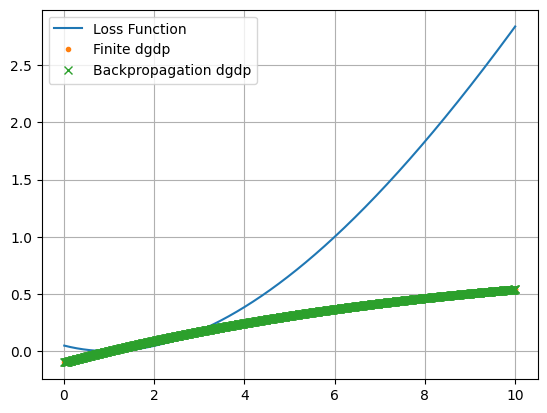

In [6]:
print(len(k_values), len(dgdp_finite), len(g_values), len(dgdp_values))
plt.plot(k_values, g_values, "-", label="Loss Function")
plt.plot(k_values, dgdp_finite, ".", label="Finite dgdp")
plt.plot(k_values, dgdp_values, "x", label="Backpropagation dgdp")
# plt.ylim(-0.1e5, 0.1e5)
print(sum(np.array(dgdp_finite) - np.array(dgdp_values)) / len(dgdp_finite))
plt.legend()
plt.grid()
plt.show()